In [15]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle
import numpy as np
from scipy.special import lambertw, gamma, zeta
from scipy.constants import h, k, c, pi, eV

In [2]:
import prince_cr.config
from prince_cr import core, util, photonfields, cross_sections
from prince_cr import util as pru

# Setup and save prince_run objects

Before you create the kernel, you can change options in the config.  
See `prince/config.py` for a full list of options

In [3]:
prince_cr.config.x_cut = 1e-4
prince_cr.config.x_cut_proton = 1e-2
prince_cr.config.tau_dec_threshold = np.inf

### Now create the objects:
- Photonfield class
- Cross section class
- PriNCe core class, that will contain the cross section kernel

(The latter two take some time)

Note that TabulatedCrossSection will look for data in the database stored in `./prince/data/prince_db_05`

In [55]:
h

6.62607015e-34

3.7754945986933084e+25 0.370208845108716


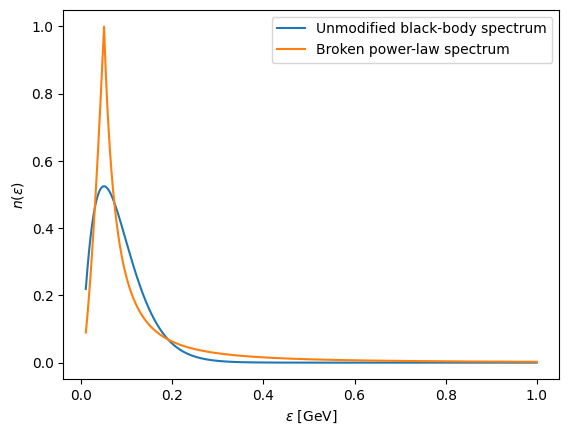

In [85]:
def broken_power_law(epsilon, n0_BPL, epsilon0=0.05e-9, alpha= 3. / 2., beta=-2.):
    """
    Evaluate the broken power-law formula for an input numpy array of epsilon values.

    Parameters:
        epsilon (numpy.ndarray): Array of epsilon values in GeV
        n0_BPL (float): Normalization constant.
        epsilon0 (float): Breakpoint in epsilon.
        alpha (float): Power-law index for epsilon < epsilon0.
        beta (float): Power-law index for epsilon >= epsilon0.

    Returns:
        numpy.ndarray: Array of n(epsilon) values.
    """
    n = np.where(
        epsilon < epsilon0,
        n0_BPL * (epsilon / epsilon0) ** alpha,
        n0_BPL * (epsilon / epsilon0) ** beta,
    )
    return n


def modified_black_body(epsilon, T, n0_MBB=1, sigma=0):
    """
    Evaluate the modified black-body spectrum for given epsilon (in GeV) and temperature T.

    Parameters:
        epsilon (numpy.ndarray): Array of epsilon values in GeV.
        T (float): Temperature in Kelvin.
        n0_MBB (float): Normalization constant (default is 1).
        sigma (float): Absorption factor exponent (default is 0).

    Returns:
        numpy.ndarray: Array of n(epsilon) values.
    """
    # Conversion factor: 1 GeV = 1e9 eV, and 1 eV = 1.60218e-19 Joules
    GeV_to_Joule = 1e9 * eV

    # Convert epsilon from GeV to Joules
    epsilon_joule = epsilon * GeV_to_Joule

    # Calculate the parameter b based on sigma
    b = sigma + 2

    # Calculate epsilon0 using the modified Wien's displacement law
    epsilon0 = (lambertw(-np.exp(-b) * b).real + b) * k * T


    # Calculate the modified black-body spectrum
    prefactor = n0_MBB * (8 * pi / (h * c) ** 3)
    exponential_term = np.exp(epsilon_joule / (k * T)) - 1
    absorption_factor = (epsilon_joule / epsilon0) ** sigma

    n = prefactor * (epsilon_joule**2 / exponential_term) * absorption_factor

    return n


def I_BPL(epsilon0, alpha, beta, n0_BPL=1):
    """
    Calculate the integral photon density for the broken power-law spectrum.

    Parameters:
        epsilon0 (float): Break energy (in same units as input energies, e.g., GeV).
        alpha (float): Power-law index for epsilon < epsilon0.
        beta (float): Power-law index for epsilon >= epsilon0.
        n0_BPL (float): Normalization constant for the BPL spectrum.

    Returns:
        float: Integral photon density I_BPL.
    """
    integral_factor = (1 / (alpha + 1)) - (1 / (beta + 1))
    return n0_BPL * epsilon0 * integral_factor


def I_MBB_sigma(T, sigma, n0_MBB=1):
    """
    Calculate the integral photon density for the modified black-body spectrum.

    Parameters:
        T (float): Temperature in Kelvin.
        sigma (float): Absorption factor exponent.
        n0_MBB (float): Normalization constant for the MBB spectrum.

    Returns:
        float: Integral photon density I_MBB_sigma.
    """
    prefactor = n0_MBB * (8 * pi / (h * c) ** 3)
    energy_factor = (k * T) ** 3
    zeta_term = zeta(sigma + 3, 1)  # Riemann zeta function ζ(σ+3,1)
    gamma_term = gamma(sigma + 3)  # Gamma function Γ(σ+3)
    return prefactor * energy_factor * zeta_term * gamma_term


def normalization_constants(epsilon0, alpha, beta, T, sigma):
    """
    Calculate normalization constants for the photon spectra.

    Parameters:
        epsilon0 (float): Break energy (in same units as input energies, e.g., GeV).
        alpha (float): Power-law index for epsilon < epsilon0.
        beta (float): Power-law index for epsilon >= epsilon0.
        T (float): Temperature in Kelvin.
        sigma (float): Absorption factor exponent.

    Returns:
        tuple: (n0_BPL, n0_MBB_sigma), normalization constants.
    """
    I_BPL_value = I_BPL(epsilon0, alpha, beta)
    I_MBB_value = I_MBB_sigma(T, sigma)
    n0_BPL = I_MBB_value / I_BPL_value
    n0_MBB_sigma = I_MBB_sigma(T, 0) / I_MBB_value  # Use σ=0 for unmodified spectrum

    return n0_BPL, n0_MBB_sigma

epsilon = np.logspace(-11, -9, 1000)  # Example epsilon values in GeV
T = 364  # Temperature in Kelvin
n0_BPL, n0_MBB = normalization_constants(0.05e-9, 3 / 2, -2, T, 1)
plt.plot(epsilon*1e9, modified_black_body(epsilon, T, n0_MBB=1e-35, sigma=0), label="Unmodified black-body spectrum")
# BPL
print(n0_BPL, n0_MBB)
plt.plot(
    epsilon*1e9, broken_power_law(epsilon, 1, epsilon0=0.05e-9), label="Broken power-law spectrum"
)
plt.xlabel(r"$\epsilon$ [GeV]")
plt.ylabel(r"$n(\epsilon)$")
plt.legend()

#### Photon field class

This is a combined photon field of CMB and Gilmore et al. EBL  
See classes in `prince/photonfields.py` for different options

In [89]:
class BrokenPowerLawSpectrum(photonfields.PhotonField):
    def __init__(self, epsilon0, alpha, beta, n0_BPL=1):
        self.epsilon0 = epsilon0
        self.alpha = alpha
        self.beta = beta
        self.n0_BPL = n0_BPL

    def get_photon_density(self, epsilon, z):
        return broken_power_law(epsilon, self.n0_BPL, self.epsilon0, self.alpha, self.beta)


#### Cross section class

This is a combined cross section of `Talys` as low energy the `Sophia` superposition model at high energies
See classes in `prince/cross_sections.py` for different options

#### Prince_run kernel

In [92]:
%%time
target_path = '../'
with open(target_path + 'prince_run_talys_test.ppo','rb') as thefile:
    prince_run_talys = pickle.load(thefile)

CPU times: user 281 ms, sys: 442 ms, total: 723 ms
Wall time: 740 ms


In [93]:
prince_run_talys.int_rates.photon_field = BrokenPowerLawSpectrum(0.05e-9, 3 / 2, -2, 1e10)

In [ ]:
solver = UHECRPropagationSolverBDF(
    initial_z=1.0,
    final_z=0.0,
    prince_run=prince_run,
    enable_pairprod_losses=True,
    enable_adiabatic_losses=True,
    enable_injection_jacobian=True,
    enable_partial_diff_jacobian=True,
)

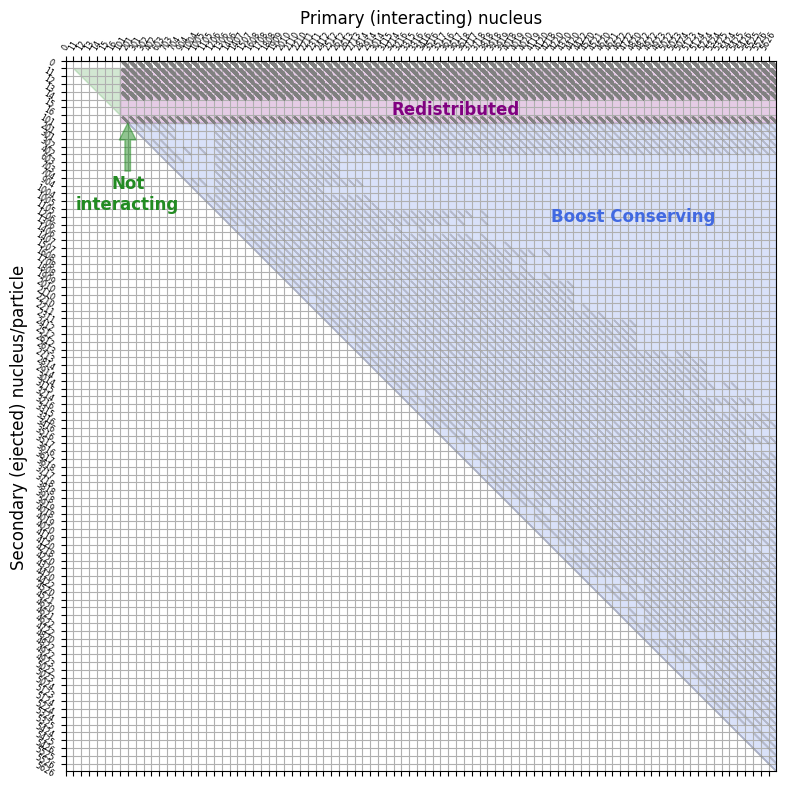

In [94]:
prince_run = prince_run_talys

precision = 0.0  # 1e-28
jac = prince_run.int_rates.get_hadr_jacobian(1.0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

photon = prince_run.spec_man.ncoid2sref[11]
proton = prince_run.spec_man.ncoid2sref[101]
iron = prince_run.spec_man.ncoid2sref[5626]

rect = plt.Polygon(
    [
        (proton.uidx(), proton.uidx()),
        (iron.uidx(), iron.uidx()),
        (iron.uidx(), proton.uidx()),
    ],
    color="royalblue",
    alpha=0.2,
)
plt.annotate(
    "Boost Conserving",
    (6400, 1750),
    color="royalblue",
    ha="center",
    va="center",
    fontsize="large",
    fontweight="bold",
)

ax.add_patch(rect)
rect = plt.Polygon(
    [
        (proton.lidx(), photon.lidx()),
        (proton.lidx(), proton.uidx()),
        (iron.uidx(), proton.uidx()),
        (iron.uidx(), photon.lidx()),
    ],
    color="purple",
    alpha=0.2,
)
ax.add_patch(rect)
plt.annotate(
    "Redistributed",
    (4400, 550),
    color="purple",
    ha="center",
    va="center",
    fontsize="large",
    fontweight="bold",
)

rect = plt.Polygon(
    [
        (photon.lidx(), photon.lidx()),
        #                     (photon.lidx(), proton.lidx()),
        (proton.lidx(), photon.lidx()),
        (proton.lidx(), proton.lidx()),
    ],
    color="forestgreen",
    alpha=0.2,
)
ax.add_patch(rect)
plt.annotate(
    "Not\ninteracting",
    (700, 700),
    xytext=(700, 1500),
    arrowprops=dict(
        facecolor="forestgreen", edgecolor="forestgreen", shrink=0.01, alpha=0.5
    ),
    color="forestgreen",
    ha="center",
    va="center",
    fontsize="large",
    fontweight="bold",
)

plt.spy(jac, markersize=0.01, precision=precision, c="gray")
# plt.imshow(np.log(np.abs(jac.todense())),origin="upper", interpolation='nearest',cmap='binary')

ticks, labels = zip(
    *[(s.lidx(), s.ncoid) for s in prince_run.spec_man.species_refs][::]
)

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=60.0, fontsize="xx-small")
ax.set_yticks(ticks)
ax.set_yticklabels(labels, rotation=-30, fontsize="xx-small")

ax.set_xlabel(r"Primary (interacting) nucleus", fontsize="large")

ax.xaxis.set_label_position("top")
ax.set_ylabel(r"Secondary (ejected) nucleus/particle", fontsize="large")
ax.grid()

plt.tight_layout()